In [4]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
plt.style.use('ggplot')
%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 300

## Problem 1

Recreate Figure 18.4 by performing PCA on the iris dataset, keeping the first two principal components.

In [3]:
iris = datasets.load_iris()
X = iris.data
Y = X - X.mean(axis=0)
U,S,VT = la.svd(Y, full_matrices=False)
S**2/(S**2).sum() # variance percentages

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

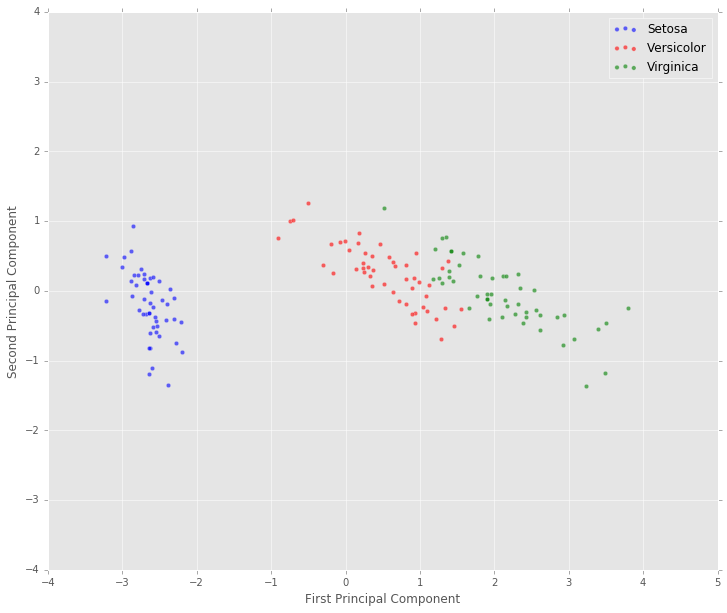

In [15]:
Yhat = Y.dot(VT.T[:,:2])
plt.figure(figsize=(12,10))
plt.scatter(Yhat[:,0][iris.target==0], Yhat[:,1][iris.target==0], c='b', alpha=.6, label='Setosa')
plt.scatter(Yhat[:,0][iris.target==1], Yhat[:,1][iris.target==1], c='r', alpha=.6, label='Versicolor')
plt.scatter(Yhat[:,0][iris.target==2], Yhat[:,1][iris.target==2], c='g', alpha=.6, label='Virginica')
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.ylim((-4,4))
plt.show()

## Problem 2

Using the techniques of LSI, applied to the word count matrix $X$, and keeping the first 7 principal components, find the most similar and least similar speeches to both Bill Clinton's 1993 speech and to Ronald Reagan's 1984 speech.

In [16]:
# Get list of filepaths to each text file in the folder.
folder = "./Addresses/"
paths = [folder+p for p in os.listdir(folder) if p[-4:]==".txt"]

# Helper function to get list of words in a string.
def extractWords(text):
    ignore = string.punctuation + string.digits
    cleaned = "".join([t for t in text.strip() if t not in ignore])
    return cleaned.lower().split()

In [20]:
# Initialize vocab set, then read each file and add to the vocab set.
vocab = set()
for p in paths:
    with open(p, 'r') as infile:
        for line in infile:
            vocab.update(extractWords(line))

In [22]:
# load stopwords
with open("stopwords.txt", 'r') as f:
    stops = set([w.strip().lower() for w in f.readlines()])

# remove stopwords from vocabulary, create ordering
vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

In [23]:
counts = []      # holds the entries of X
doc_index = []   # holds the row index of X
word_index = []  # holds the column index of X

# Iterate through the documents.
for doc, p in enumerate(paths):
    with open(p, 'r') as f:
        # Create the word counter.
        ctr = Counter()
        for line in f:
            ctr.update(extractWords(line))
        # Iterate through the word counter, store counts.
        for word, count in ctr.items():
            if word in vocab:
                word_index.append(vocab[word])
                counts.append(count)
                doc_index.append(doc)

# Create sparse matrix holding these word counts.
X = sparse.csr_matrix((counts, [doc_index, word_index]),
                       shape=(len(paths), len(vocab)), dtype=np.float)

In [31]:
l = 7
u, s, vt = spla.svds(X,k=l)
Xhat = X.dot(vt.T[:,:l])

def find_speeches(i,Z):
    '''Returns most and least similar speech.
    
    Arguments:
    i - index for speech to be considered
    Z - data that has already been PCA-ed
    
    Returns:
    most similar speech
    least similar speech
    '''
    
    # find vector representing year
    speech = Z[i]
    speech_norm = la.norm(speech)
    cosines = np.zeros(len(Z))
    
    # compare that vector to all others
    for j in range(len(Z)):
        if j!=i:
            cosines[j] = speech.dot(Z[j])/(la.norm(Z[j])*speech_norm)
        else: # All this is for is to ensure the same year doesn't get the max or min
            cosines[j] = cosines[:j].mean()
            
    # return the year and president for most similar and least similar
    return paths[np.argmax(cosines)].split('/')[-1][:-4], paths[np.argmin(cosines)].split('/')[-1][:-4]


def find_index(year):
    '''Returns the index corresponding to the year of the SOTU address
    
    Arguments:
    year - string or int for which year the SOTU address happened
    
    Returns:
    i - index for that in the matrix X
    '''
    # Ensure it is a string
    year = str(year)
    index = 0
    for p in paths:
        if year in p:
            break
        index += 1
    return index

In [37]:
clinton93 = find_index('1993')
reagan84 = find_index('1984')

results93 = find_speeches(clinton93, Xhat)
results84 = find_speeches(reagan84, Xhat)
print("Speech Analyzed\t| Most Similar\t| Least Similar")
print("-----------------------------------------------")
print("Clinton 1993\t| {}\t| {}".format(results93[0],results93[1]))
print("Reagan 1984\t| {}\t| {}".format(results84[0],results84[1]))

Speech Analyzed	| Most Similar	| Least Similar
-----------------------------------------------
Clinton 1993	| 2010-Obama	| 1951-Truman
Reagan 1984	| 1988-Reagan	| 1946-Truman


Yes, the results are plausible because both Clinton and Obama are Democrats speaking early in their first term and Reagan's most similar is also an election year and also by himself. However, I am a little surprised that Obama 2010's speech is MOST similar. Truman makes sense for both, because his speech is from a totally different generation.

## Problem 3

Repeat Problem 2 using the matrix $A$.
Do your answers seem more reasonable than before?

In [38]:
t = np.zeros(len(vocab))
counts = []
doc_index = []
word_index = []

# get doc-term counts and global term counts
for doc, path in enumerate(paths):
    with open(path, 'r') as f:
        # create the word counter
        ctr = Counter()
        for line in f:
            words = extractWords(line)
            ctr.update(words)
        # iterate through the word counter, store counts
        for word, count in ctr.items():
            if word in vocab:
                word_ind = vocab[word]
                word_index.append(word_ind)
                counts.append(count)
                doc_index.append(doc)
                t[word_ind] += count

# Get global weights.
g = np.ones(len(vocab))
logM = log(len(paths))
for count, word in zip(counts, word_index):
    p = count/float(t[word])
    g[word] += p*log(p+1)/logM

# Get globally weighted counts.
gwcounts = []
for count, word in zip(counts, word_index):
    gwcounts.append(g[word]*log(count+1))

# Create sparse matrix holding these globally weighted word counts
A = sparse.csr_matrix((gwcounts, [doc_index,word_index]),
                      shape=(len(paths), len(vocab)), dtype=np.float)


In [39]:
u2, s2, vt2 = spla.svds(A,k=l)
Ahat = A.dot(vt2.T[:,:l])

newresults93 = find_speeches(clinton93, Ahat)
newresults84 = find_speeches(reagan84, Ahat)
print("Speech Analyzed\t| Most Similar\t| Least Similar")
print("-----------------------------------------------")
print("Clinton 1993\t| {}\t| {}".format(newresults93[0],newresults93[1]))
print("Reagan 1984\t| {}\t| {}".format(newresults84[0],newresults84[1]))

Speech Analyzed	| Most Similar	| Least Similar
-----------------------------------------------
Clinton 1993	| 1992-Bush	| 1946-Truman
Reagan 1984	| 1985-Reagan	| 1946-Truman


I would say these results do look better. It makes more sense to see that the most similar speeches would be speeches closer in time because then the issues haven't changed as much year to year, whereas we would expect the issues to have changed more from 1993 to 2010. It still makes sense that Truman's speech is most different, because it is in a totally different generation.